### MSE - T-MachLe
# PW 04

{dorian.magnin, noemien.kocher}@master.hes-so.ch

## Exercice 1 Classification system

### a. Getting started

#### a) + b)

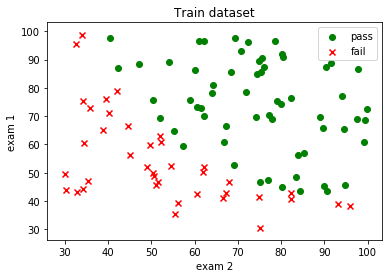

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import inv

dataset = pd.read_csv('ex1-data-train.csv',
                        header=0,
                        names=['x1', 'x2', 'y'])

x1 = dataset['x1'].values
x2 = dataset['x2'].values
y = dataset['y'].values
N = len(x1)

ones_x1 = [x1[i] for i in range(0, N) if y[i] == 1]
ones_x2 = [x2[i] for i in range(0, N) if y[i] == 1]

zero_x1 = [x1[i] for i in range(0, N) if y[i] == 0]
zero_x2 = [x2[i] for i in range(0, N) if y[i] == 0]

plt.scatter(ones_x1, ones_x2, marker="o", label="pass", color="green")
plt.scatter(zero_x1, zero_x2, marker="x", label="fail", color="red")
plt.legend()
plt.title("Train dataset")
plt.ylabel("exam 1")
plt.xlabel("exam 2")
plt.show()

#### c)

In [23]:
import random

def blindTest(x1, x2):
    test = random.random()
    return 1 if test > 0.5 else 0

#### d)


In [34]:
true_guess = 0
for i in range(0, len(x1)):
    guess = blindTest(x1[i], x2[i])
    if guess == y[i]:
        true_guess = true_guess + 1

print("Performance: ", true_guess/N)

Performance:  0.5050505050505051


### b. K-nn classifier

In [40]:
from sklearn.neighbors import NearestNeighbors
X = []
for i in range(0, N):
    X.append([x1[i], x2[i]])

print(NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X).kneighbors(X))

print("N: ", N)

(array([[  0.        ,   2.50603857,   3.93793144],
       [  0.        ,   2.86754091,   4.71973464],
       [  0.        ,   6.71717619,   6.85465894],
       [  0.        ,   1.49240131,   3.46630319],
       [  0.        ,   5.69901033,   5.96383333],
       [  0.        ,   1.00009069,   8.34570571],
       [  0.        ,   2.20514107,   4.98616248],
       [  0.        ,   1.80337393,   2.48976997],
       [  0.        ,   2.35137005,   3.57189022],
       [  0.        ,   2.8067773 ,   7.41134966],
       [  0.        ,  10.97244697,  12.4256787 ],
       [  0.        ,   3.31016518,   3.46630319],
       [  0.        ,   3.33393707,   4.96396957],
       [  0.        ,   3.78439942,   4.84239244],
       [  0.        ,   6.74655536,   6.85465894],
       [  0.        ,   6.16509171,   6.88109818],
       [  0.        ,   3.88292029,   5.75583203],
       [  0.        ,   3.70569522,   4.96396957],
       [  0.        ,   2.20514107,   4.23077187],
       [  0.        ,   1.9255